In [1]:
import pandas
import pyspark
import pyspark.sql
from pyspark.sql                import SparkSession, DataFrame
import pyspark.sql.types        as T
import pyspark.sql.functions    as F
import lib.pyspark_helper       as helper
import lib.visualizer           as visualizer
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
spark = SparkSession.builder.master('local[*]').appName('risk').getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

## Repairs

In [3]:
df_repairs = spark.read.csv('./out/repairs.csv',header=True)
df_repairs = df_repairs.withColumn('date',F.col('date').cast(T.DateType())) 
df_repairs = df_repairs.sort(F.col('date'),ascending=True)
visualizer.visualise_dataframe(df_repairs)

root
 |-- part: string (nullable = true)
 |-- date: date (nullable = true)
 |-- serial_number: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- client: string (nullable = true)
 |-- final_assessment: string (nullable = true)
 |-- part_number: string (nullable = true)
 |-- part_description: string (nullable = true)
 |-- model_name: string (nullable = true)

Number of records: 118812
-RECORD 0------------------------------
 part             | mainboard resistor 
 date             | null               
 serial_number    | 18036WL83904913    
 item_type        | IWL255-01T3807A    
 client           | ABSA               
 final_assessment | repaired           
 part_number      | 2                  
 part_description | MAINBOARD RESISTOR 
 model_name       | IWL                
only showing top 1 row



## Item Type

In [4]:
df_items = df_repairs\
    .groupBy(
        F.col('part'),
        F.col('serial_number'),
        F.col('item_type'),
        F.col('client'),
        F.col('final_assessment')    
    )\
    .count()\
    .withColumnRenamed(
        'count', 
        'repairs'
    )\
    .join(
        df_repairs.select(
            F.col('serial_number')
        ).distinct()\
        .where(
            F.col('final_assessment') == 'scrapped'
        ).withColumn(
            'scrapped', 
            F.lit(True)
        ),
        ['serial_number'],
        'full'
    )\
    .withColumn(
        'scrapped', 
        F.when(F.col('scrapped').isNull(), F.lit(False)).otherwise(F.lit(True))
    )

visualizer.visualise_dataframe(df_items)

root
 |-- serial_number: string (nullable = true)
 |-- part: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- client: string (nullable = true)
 |-- final_assessment: string (nullable = true)
 |-- repairs: long (nullable = true)
 |-- scrapped: boolean (nullable = false)

Number of records: 98207
-RECORD 0---------------------------
 serial_number    | 001005502887242 
 part             | cleaned         
 item_type        | Ingenico ICT    
 client           | FNB             
 final_assessment | repaired        
 repairs          | 1               
 scrapped         | false           
only showing top 1 row



serial_number
+-------+-----+-----------------+-------------------+
|repairs|total|not_scrapped     |scrapped           |
+-------+-----+-----------------+-------------------+
|1      |14293|68.26418526551458|31.735814734485412 |
|2      |10639|95.12172196635022|4.878278033649779  |
|3      |4777 |99.45572535063847|0.544274649361524  |
|4      |3431 |99.44622559020694|0.5537744097930632 |
|5      |2107 |99.66777408637874|0.33222591362126247|
|6      |1475 |99.59322033898304|0.4067796610169492 |
|7      |936  |99.78632478632478|0.2136752136752137 |
|8      |757  |99.8678996036988 |0.13210039630118892|
+-------+-----+-----------------+-------------------+
only showing top 8 rows



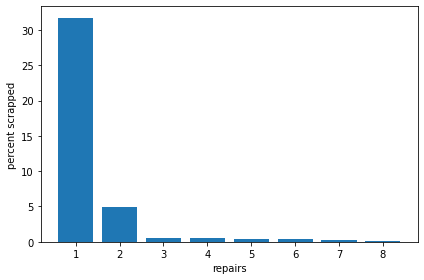

part
+-------+-----+-----------------+------------------+
|repairs|total|not_scrapped     |scrapped          |
+-------+-----+-----------------+------------------+
|1      |75   |72.0             |28.000000000000004|
|2      |27   |51.85185185185185|48.148148148148145|
|3      |15   |60.0             |40.0              |
|4      |15   |33.33333333333333|66.66666666666666 |
|5      |13   |38.46153846153847|61.53846153846154 |
|6      |3    |0.0              |100.0             |
|7      |8    |50.0             |50.0              |
|8      |8    |25.0             |75.0              |
+-------+-----+-----------------+------------------+
only showing top 8 rows



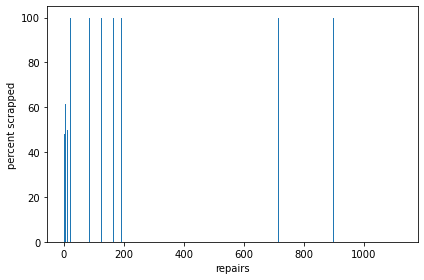

client
+-------+-----+-----------------+-----------------+
|repairs|total|not_scrapped     |scrapped         |
+-------+-----+-----------------+-----------------+
|1      |4    |25.0             |75.0             |
|3      |2    |50.0             |50.0             |
|4      |3    |33.33333333333333|66.66666666666666|
|11     |1    |100.0            |0.0              |
|26     |1    |100.0            |0.0              |
|40     |1    |100.0            |0.0              |
|45     |1    |100.0            |0.0              |
|68     |1    |100.0            |0.0              |
+-------+-----+-----------------+-----------------+
only showing top 8 rows



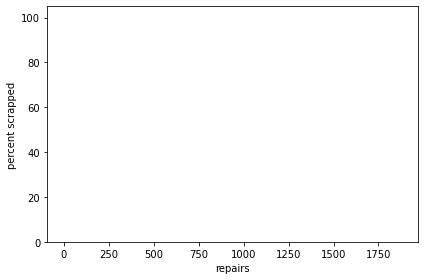

item_type
+-------+-----+-----------------+-----------------+
|repairs|total|not_scrapped     |scrapped         |
+-------+-----+-----------------+-----------------+
|1      |13   |38.46153846153847|61.53846153846154|
|2      |11   |54.54545454545454|45.45454545454545|
|3      |4    |25.0             |75.0             |
|4      |2    |50.0             |50.0             |
|5      |6    |33.33333333333333|66.66666666666666|
|6      |3    |100.0            |0.0              |
|7      |3    |66.66666666666666|33.33333333333333|
|8      |2    |0.0              |100.0            |
+-------+-----+-----------------+-----------------+
only showing top 8 rows



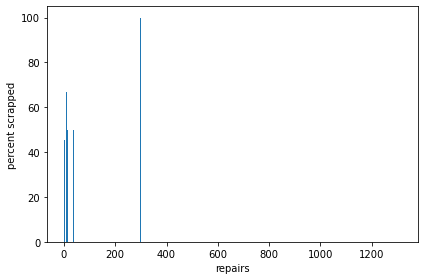

part and item type
+-------+-----+-----------------+------------------+
|repairs|total|not_scrapped     |scrapped          |
+-------+-----+-----------------+------------------+
|1      |676  |66.71597633136095|33.28402366863905 |
|2      |276  |65.21739130434783|34.78260869565217 |
|3      |139  |76.2589928057554 |23.741007194244602|
|4      |106  |74.52830188679245|25.471698113207548|
|5      |74   |83.78378378378379|16.216216216216218|
|6      |61   |77.04918032786885|22.950819672131146|
|7      |45   |82.22222222222221|17.77777777777778 |
|8      |54   |68.51851851851852|31.48148148148148 |
+-------+-----+-----------------+------------------+
only showing top 8 rows



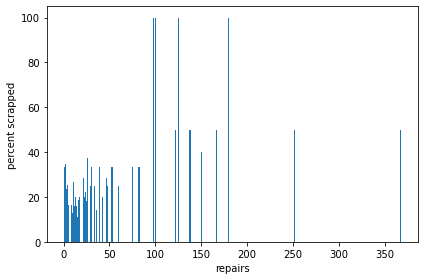

part, item type, client
+-------+-----+-----------------+------------------+
|repairs|total|not_scrapped     |scrapped          |
+-------+-----+-----------------+------------------+
|1      |753  |68.26029216467462|31.739707835325365|
|2      |322  |68.01242236024845|31.987577639751553|
|3      |158  |74.68354430379746|25.31645569620253 |
|4      |123  |78.86178861788618|21.138211382113823|
|5      |80   |83.75            |16.25             |
|6      |68   |77.94117647058823|22.058823529411764|
|7      |51   |78.43137254901961|21.568627450980394|
|8      |63   |74.60317460317461|25.396825396825395|
+-------+-----+-----------------+------------------+
only showing top 8 rows



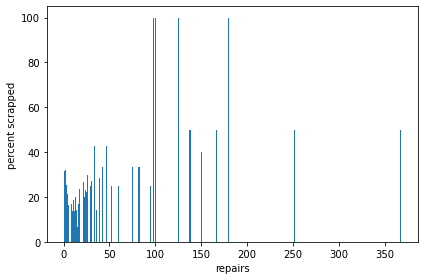

part, item type, serial_number
+-------+-----+-----------------+-----------------+
|repairs|total|not_scrapped     |scrapped         |
+-------+-----+-----------------+-----------------+
|1      |79892|94.04571171080958|5.954288289190407|
|2      |16879|96.8481545115232 |3.151845488476805|
|3      |738  |100.0            |0.0              |
|4      |529  |100.0            |0.0              |
|5      |36   |100.0            |0.0              |
|6      |74   |100.0            |0.0              |
|7      |2    |100.0            |0.0              |
|8      |16   |100.0            |0.0              |
+-------+-----+-----------------+-----------------+
only showing top 8 rows



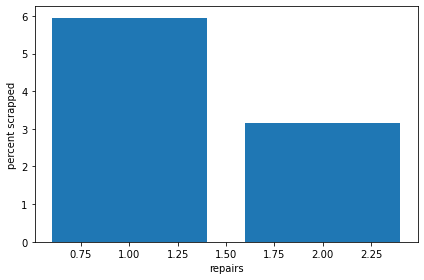

In [26]:
def print_and_plot(df_group): 
    #df_group = visualizer.create_repair_ration(df_items.groupBy(col,'scrapped').sum('repairs').withColumnRenamed('sum(repairs)', 'repairs'))
    df_group.show(8,truncate=False)
    x = [row[0] for row in df_group.select('repairs').where(~F.col('scrapped').eqNullSafe(0.0)).collect()]
    y = [row[0] for row in df_group.select('scrapped').where(~F.col('scrapped').eqNullSafe(0.0)).collect()]

    plt.bar(x,y,align='center')
    plt.xlabel('repairs')
    plt.ylabel('percent scrapped')
    # for i in range(len(y)):
    #     plt.hlines(y[i],0,x[i]) # Here you are drawing the horizontal lines
    plt.tight_layout()
    plt.show()

for col in ['serial_number','part','client','item_type']:
    print(col) 
    print_and_plot(visualizer.create_repair_ration(df_items.groupBy(col,'scrapped').sum('repairs').withColumnRenamed('sum(repairs)', 'repairs')))

print('part and item type')
print_and_plot(visualizer.create_repair_ration(df_items.groupBy('part','item_type','scrapped').sum('repairs').withColumnRenamed('sum(repairs)', 'repairs')))
 
print('part, item type, client')
print_and_plot(visualizer.create_repair_ration(df_items.groupBy('part','item_type','client','scrapped').sum('repairs').withColumnRenamed('sum(repairs)', 'repairs')))

print('part, item type, serial_number')
print_and_plot(visualizer.create_repair_ration(df_items.groupBy('part','item_type','serial_number','scrapped').sum('repairs').withColumnRenamed('sum(repairs)', 'repairs')))

## item type repair disribution

[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1]


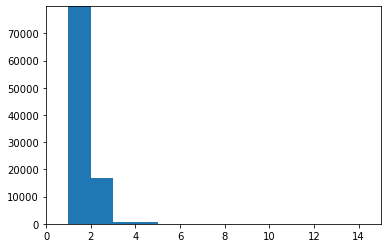

In [33]:
ls_items_types = [row[0] for row in df_items.select('repairs').collect()]
print(ls_items_types[:20])
interval = 1
bins = np.arange(0, max(ls_items_types), interval)
y, x, _ = plt.hist(ls_items_types, bins=bins, log=False)

plt.xlim([0, x.max()])
plt.ylim([0, y.max()])
plt.show()

#visualizer.plot_histogram(df_items,'repairs')

## part repair distribution 

[16, 10, 10, 10, 10, 10, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


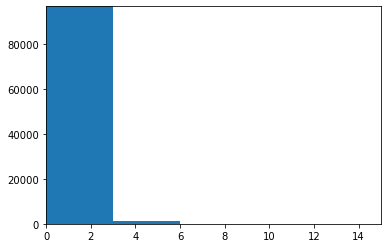

In [34]:
ls_parts = [row[0] for row in df_parts.select('repairs').collect()]
print(ls_parts[:20])
interval = 3
bins = np.arange(0, max(ls_parts), interval)
y, x, _ = plt.hist(ls_parts, bins=bins, log=False)

plt.xlim([0, x.max()])
plt.ylim([0, y.max()])
plt.show()
# visualizer.plot_histogram(df_parts,'repairs')